In [ ]:
import pickle as pkl
import statistics
import time
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

load_dotenv()

import dataloader
import util

util.set_seed(22)

c:\Users\risko\Desktop\Prompt-Classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasets = dataloader.get_domain_data()
eval_datasets = dataloader.get_eval_datasets()
batch_data = dataloader.get_batch_data()

batch_sizes = [1, 32, 64, 128, 256]

In [3]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5", providers=["CUDAExecutionProvider"]
)
mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    providers=["CUDAExecutionProvider"],
)

tfidf_embedding = TfidfVectorizer()

c:\Users\risko\Desktop\Prompt-Classification\.venv\Lib\site-packages\fastembed\common\onnx_model.py:100: RuntimeWarning: Attempt to set CUDAExecutionProvider failed. Current providers: ['CPUExecutionProvider'].If you are using CUDA 12.x, install onnxruntime-gpu via `pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/`
  warnings.warn(


In [4]:
first_dataset = next(iter(datasets.values()))["prompt"]
train_prompts = first_dataset.sample(frac=0.8, random_state=22)

tfidf_embedding.fit(train_prompts)

with open("models/tfidf.pkl", "wb") as f:
    pkl.dump(tfidf_embedding, f)

# Create embedding cache directory
os.makedirs("cache/embeddings", exist_ok=True)

In [5]:
embedding_models = {
    "mini": mini_embedding,
    "tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

# Cache

In [6]:
def get_cached_embeddings(texts, model_name, domain, cache_dir="cache/embeddings"):
    """Get embeddings from cache if available, otherwise compute and cache them."""
    cache_file = f"{cache_dir}/{domain}_{model_name}_embeddings.pkl"
    
    # Check if cache exists
    if os.path.exists(cache_file):
        print(f"Loading cached embeddings for {domain} using {model_name}")
        with open(cache_file, 'rb') as f:
            return pkl.load(f)
    
    # Cache doesn't exist, compute embeddings
    print(f"Computing embeddings for {domain} using {model_name}...")
    
    if model_name == "tf_idf":
        embeddings = tfidf_embedding.transform(texts)
    else:
        # Get the appropriate embedding model
        embed_model = embedding_models[model_name]
        
        # Process in batches for better memory efficiency
        batch_size = 1  # Adjust based on available RAM
        all_embeddings = []
        
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            batch_embeddings = list(embed_model.embed(batch_texts))
            all_embeddings.extend(batch_embeddings)
            
        embeddings = np.array(all_embeddings)
    
    # Cache the results
    with open(cache_file, 'wb') as f:
        pkl.dump(embeddings, f)
    
    return embeddings

# Train

Loading cached embeddings for finance_train using mini
Loading cached embeddings for finance_test using mini
Embedding time for mini: 1254.7777777777778 ns
Cross-validation accuracy: 0.99
Training accuracy: 1.00


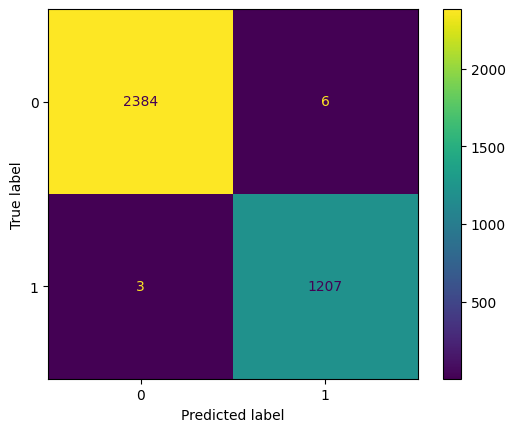

Loading cached embeddings for finance_train using tf_idf
Loading cached embeddings for finance_test using tf_idf
Embedding time for tf_idf: 1749.048611111111 ns
Cross-validation accuracy: 0.99
Training accuracy: 1.00


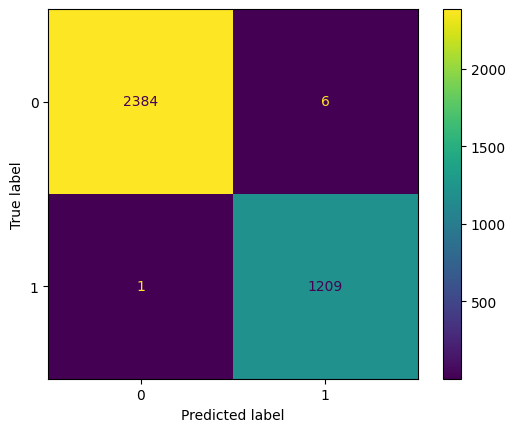

Loading cached embeddings for finance_train using baai
Loading cached embeddings for finance_test using baai
Embedding time for baai: 2078.4305555555557 ns
Cross-validation accuracy: 0.99
Training accuracy: 1.00


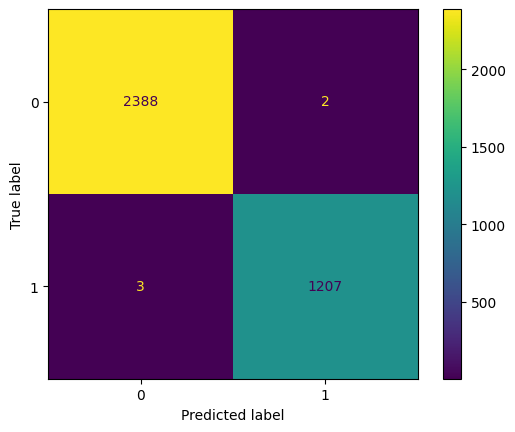

Loading cached embeddings for healthcare_train using mini
Loading cached embeddings for healthcare_test using mini
Embedding time for mini: 2129.7083333333335 ns
Cross-validation accuracy: 0.99
Training accuracy: 1.00


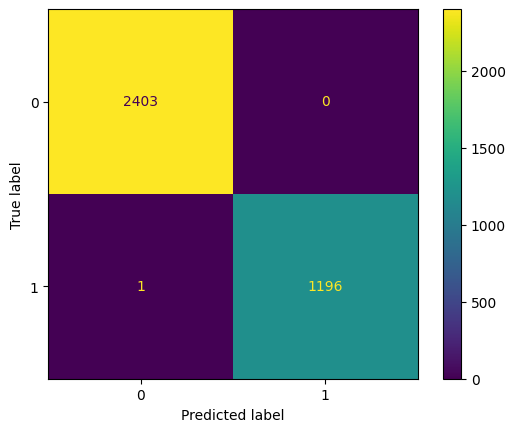

Loading cached embeddings for healthcare_train using tf_idf
Loading cached embeddings for healthcare_test using tf_idf
Embedding time for tf_idf: 1765.1666666666667 ns
Cross-validation accuracy: 0.97
Training accuracy: 1.00


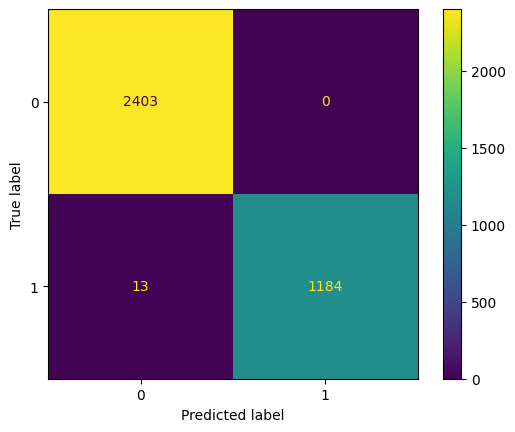

Loading cached embeddings for healthcare_train using baai
Loading cached embeddings for healthcare_test using baai
Embedding time for baai: 2244.527777777778 ns
Cross-validation accuracy: 0.99
Training accuracy: 1.00


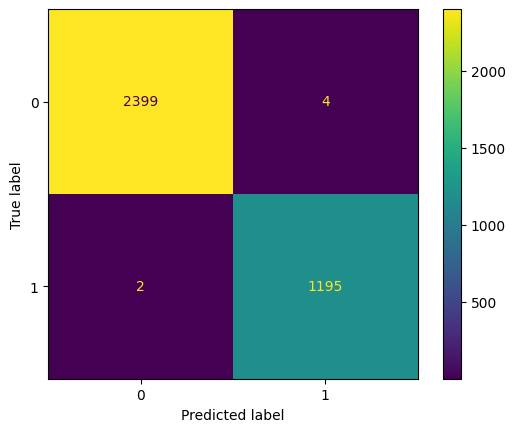

Loading cached embeddings for law_train using mini
Loading cached embeddings for law_test using mini
Embedding time for mini: 2053.6180555555557 ns
Cross-validation accuracy: 0.99
Training accuracy: 1.00


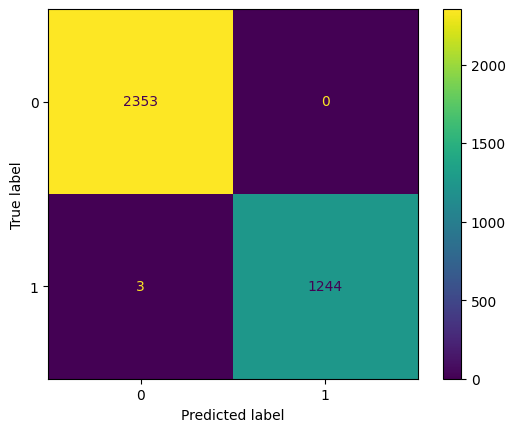

Loading cached embeddings for law_train using tf_idf
Loading cached embeddings for law_test using tf_idf
Embedding time for tf_idf: 1638.826388888889 ns
Cross-validation accuracy: 0.96
Training accuracy: 1.00


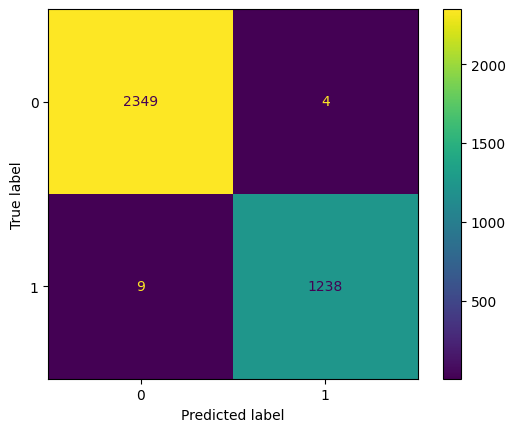

Loading cached embeddings for law_train using baai
Loading cached embeddings for law_test using baai
Embedding time for baai: 1967.9652777777778 ns
Cross-validation accuracy: 0.98
Training accuracy: 1.00


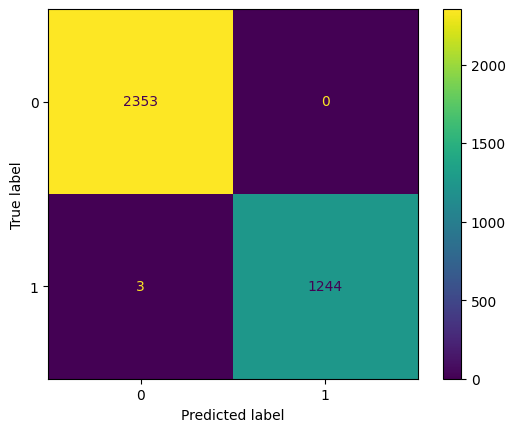

In [7]:
for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.8, random_state=22).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    for model_name, embedding_model in embedding_models.items():
        start_time = time.perf_counter_ns()
        
        # Get cached or compute new embeddings
        train_embeds = get_cached_embeddings(train_data["prompt"], model_name, f"{domain}_train")
        test_embeds = get_cached_embeddings(test_data["prompt"], model_name, f"{domain}_test")
        
        end_time = time.perf_counter_ns()
        embed_times = end_time - start_time
        mean_embed_time = embed_times / len(train_data + test_data)

        print(f"Embedding time for {model_name}: {mean_embed_time} ns")

        # Train and evaluate XGBoost model
        util.train_and_evaluate_model(
            model_name="XGBoost",
            train_embeds=train_embeds,
            test_embeds=test_embeds,
            train_labels=train_data["label"],
            test_labels=test_data["label"],
            domain=domain,
            embed_model=model_name,
            save_path=f"models/XGBoost_{domain}_{model_name}.json",
            embedding_time=mean_embed_time,
            training=True,
        )

# Eval

In [8]:
# Load TF-IDF model
with open("models/tfidf.pkl", "rb") as f:
    tfidf_embedding = pkl.load(f)

embedding_models = {
    "mini": mini_embedding,
    "tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

Loading cached embeddings for jigsaw_eval using mini


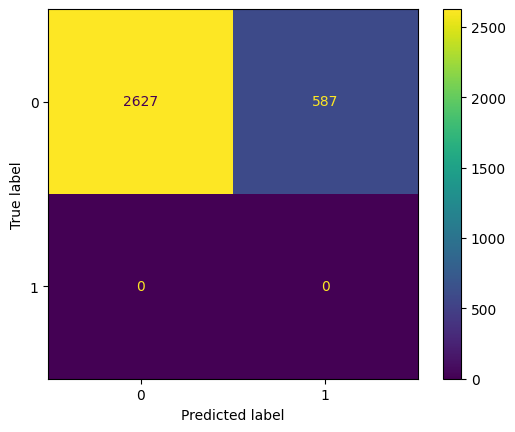

Loading cached embeddings for olid_eval using mini


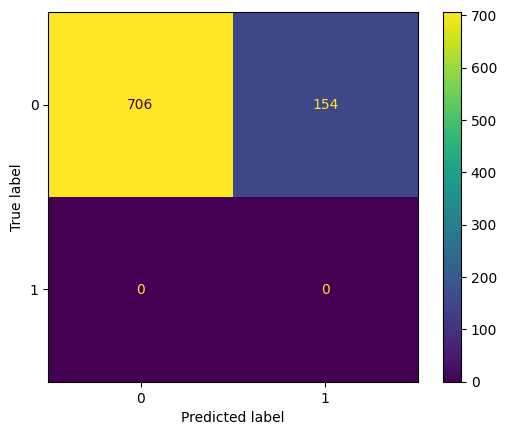

Loading cached embeddings for hate_xplain_eval using mini


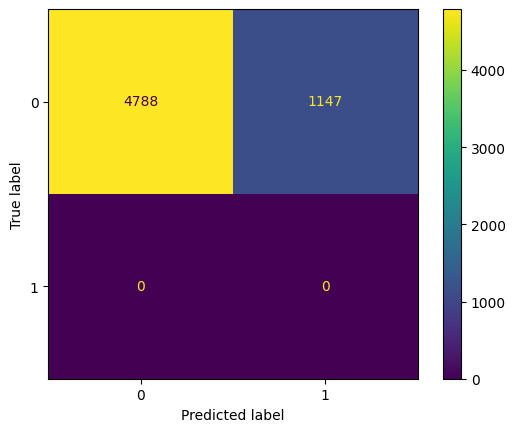

Loading cached embeddings for tuke_sk_eval using mini


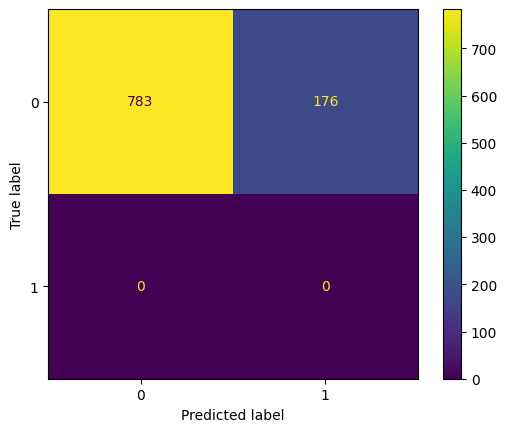

Loading cached embeddings for dkk_eval using mini


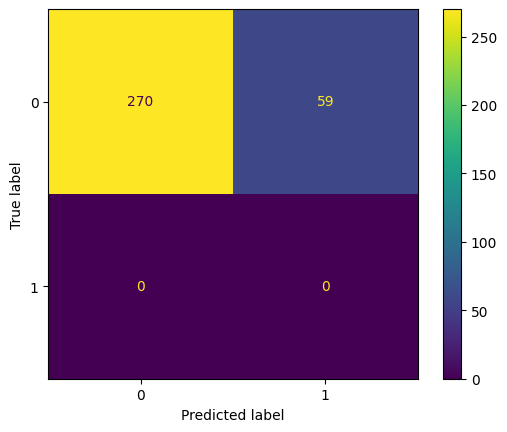

Loading cached embeddings for web_questions_eval using mini


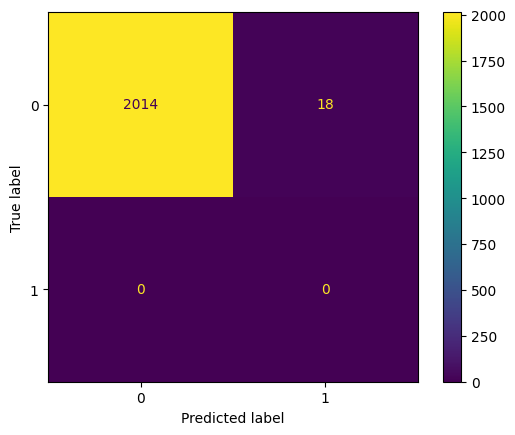

Loading cached embeddings for ml_questions_eval using mini


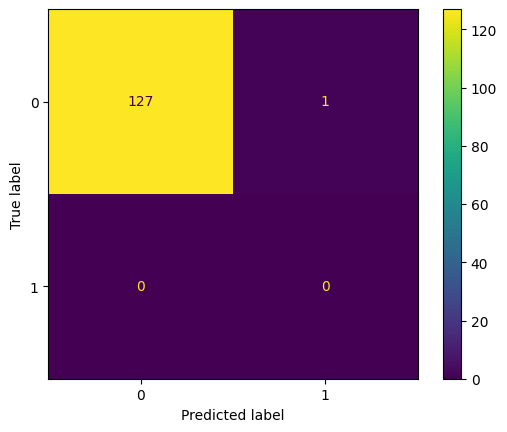

Loading cached embeddings for jigsaw_eval using tf_idf


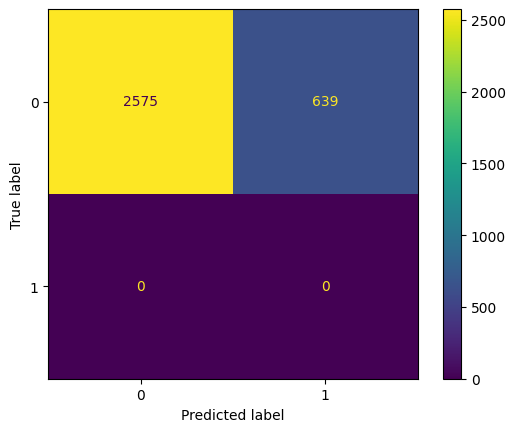

Loading cached embeddings for olid_eval using tf_idf


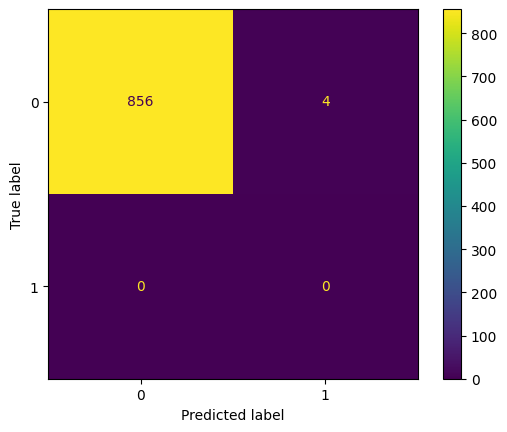

Loading cached embeddings for hate_xplain_eval using tf_idf


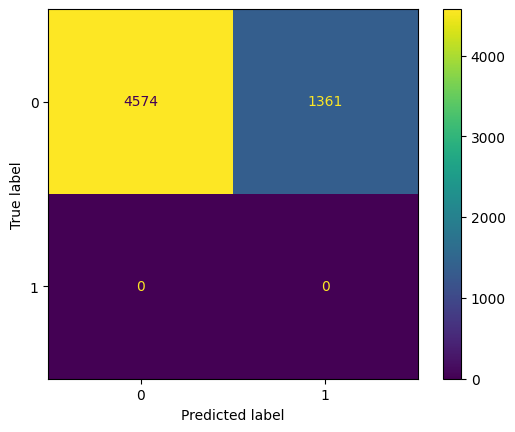

Loading cached embeddings for tuke_sk_eval using tf_idf


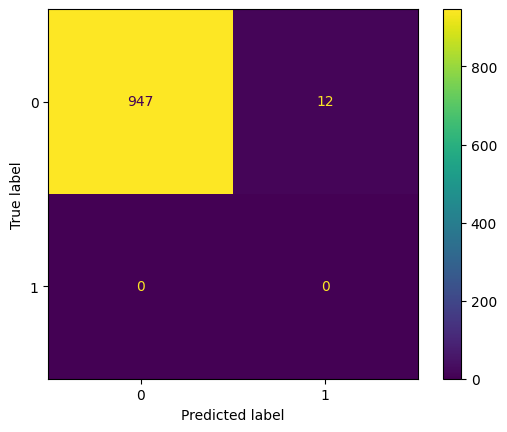

Loading cached embeddings for dkk_eval using tf_idf


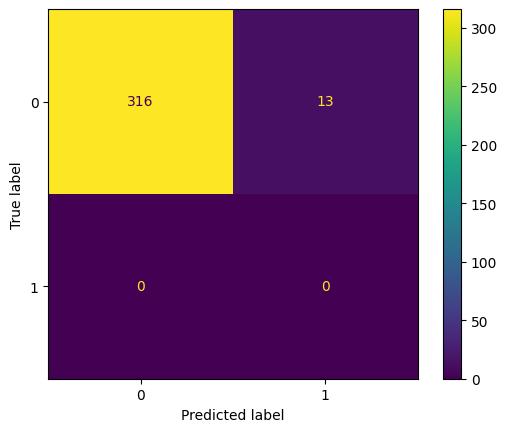

Loading cached embeddings for web_questions_eval using tf_idf


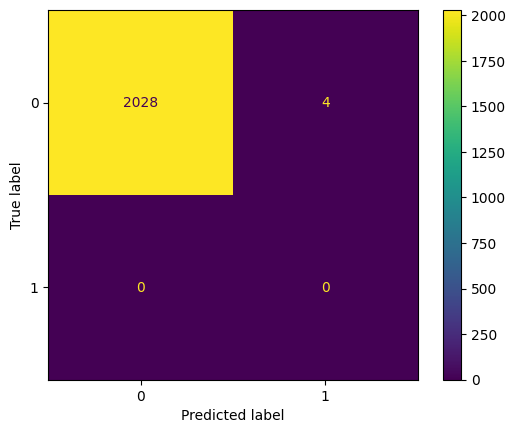

Loading cached embeddings for ml_questions_eval using tf_idf


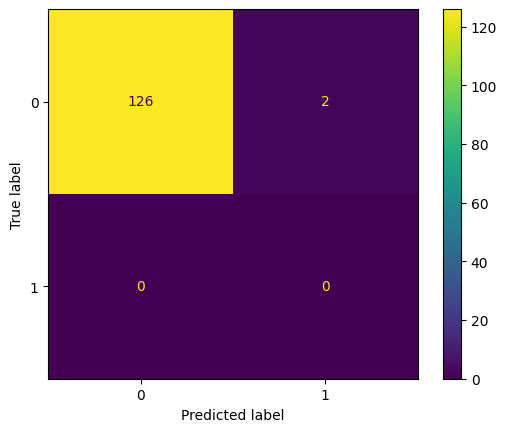

Loading cached embeddings for jigsaw_eval using baai


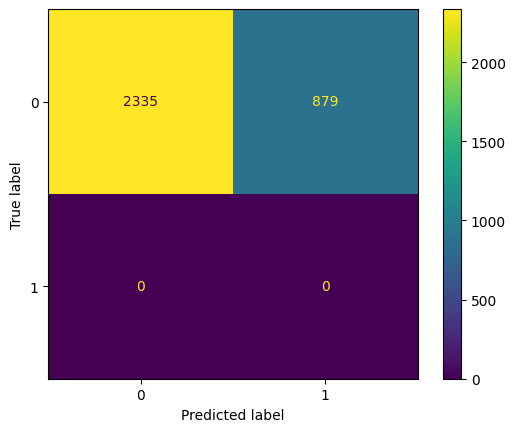

Loading cached embeddings for olid_eval using baai


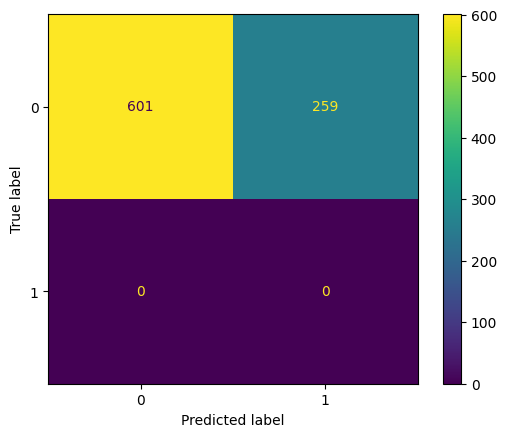

Loading cached embeddings for hate_xplain_eval using baai


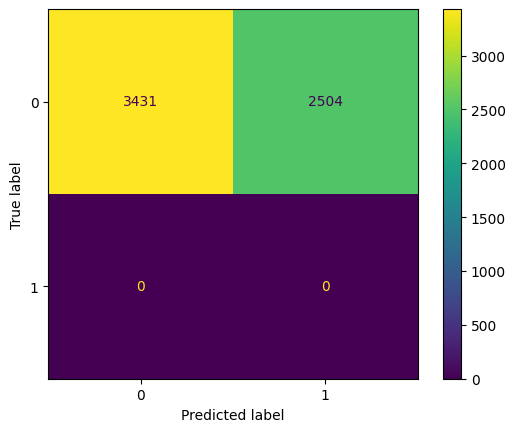

Loading cached embeddings for tuke_sk_eval using baai


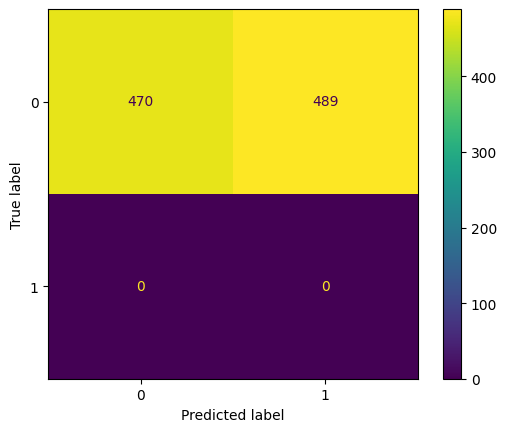

Loading cached embeddings for dkk_eval using baai


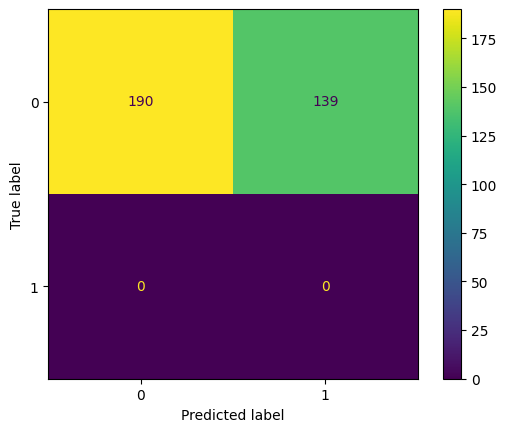

Loading cached embeddings for web_questions_eval using baai


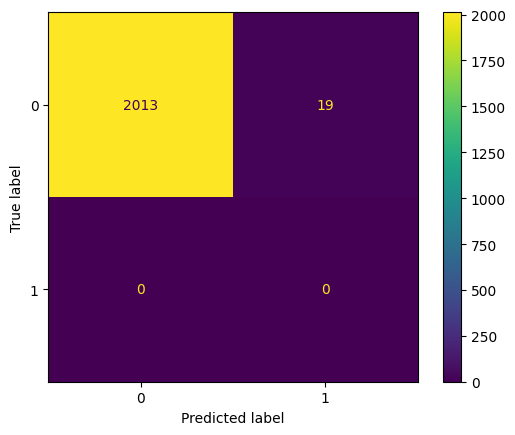

Loading cached embeddings for ml_questions_eval using baai


c:\Users\risko\Desktop\Prompt-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


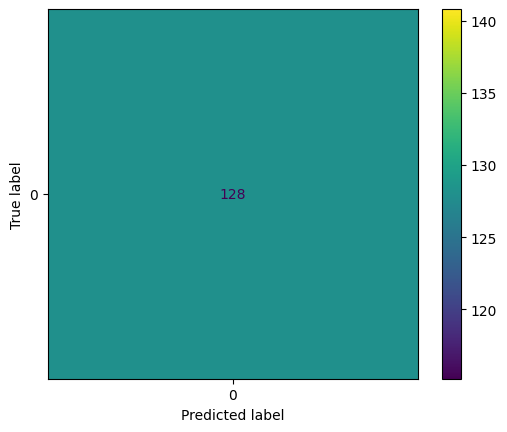

In [ ]:
for embed_model_name, embedding_model in embedding_models.items():
    xgb_law = XGBClassifier(
        tree_method="hist",
        device="cuda",
    )
    xgb_finance = XGBClassifier(
        tree_method="hist",
        device="cuda",
    )
    xgb_healthcare = XGBClassifier(
        tree_method="hist",
        device="cuda",
    )

    xgb_law.load_model(f"models/XGBoost_law_{embed_model_name}.json")
    xgb_finance.load_model(f"models/XGBoost_finance_{embed_model_name}.json")
    xgb_healthcare.load_model(f"models/XGBoost_healthcare_{embed_model_name}.json")

    for domain, inference_df in eval_datasets.items():
        actuals_ml = inference_df["label"].tolist()

        # Use cached embeddings or compute new ones
        embeds = get_cached_embeddings(inference_df["prompt"], embed_model_name, f"{domain}_eval")

        predictions_xgb = []
        prediction_times_xgb = []

        # Batch prediction for better performance
        start_time = time.perf_counter_ns()
        pred_finance = xgb_finance.predict(embeds)
        pred_healthcare = xgb_healthcare.predict(embeds)
        pred_law = xgb_law.predict(embeds)
        end_time = time.perf_counter_ns()
        
        prediction_time = end_time - start_time
        prediction_times_xgb = [prediction_time / embeds.shape[0]] * embeds.shape[0]
        
        # Combine predictions
        predictions_xgb = [0 if (f == 1 or h == 1 or l == 1) else 1 
                         for f, h, l in zip(pred_finance, pred_healthcare, pred_law, strict=True)]

        util.evaluate_run(
            predictions=predictions_xgb,
            true_labels=actuals_ml,
            latency=statistics.mean(prediction_times_xgb),
            domain=domain,
            embed_model=embed_model_name,
            model_name="XGBoost",
            train_acc=0.0,
            cost=0.0,
            training=False,
        )
        

# Batch

In [14]:
for embedding_model_name in ["mini", "baai", "tf_idf"]:
    # Load models
    xgb_law = XGBClassifier(tree_method="hist", device="cuda")
    xgb_finance = XGBClassifier(tree_method="hist", device="cuda")
    xgb_healthcare = XGBClassifier(tree_method="hist", device="cuda")

    xgb_law.load_model(f"models/XGBoost_law_{embedding_model_name}.json")
    xgb_finance.load_model(f"models/XGBoost_finance_{embedding_model_name}.json")
    xgb_healthcare.load_model(f"models/XGBoost_healthcare_{embedding_model_name}.json")

    xgb_batch_results = []

    for batch_size in batch_sizes:
        print(f"Processing batch size {batch_size} with {embedding_model_name} embeddings")
        batches = [
            batch_data[i : i + batch_size] for i in range(0, len(batch_data), batch_size)
        ]
        for batch in tqdm(batches):
            batch_metrics = {
                "embed_time": 0,
                "xgb_law_time": 0,
                "xgb_finance_time": 0,
                "xgb_health_time": 0
            }

            # Time embeddings
            start_time = time.perf_counter()
            embedding_model = embedding_models[embedding_model_name]
            if embedding_model_name == "tf_idf":
                embeds = embedding_model.transform(batch)
            else:
                embeds = np.array(list(embedding_model.embed(batch)))
            batch_metrics['embed_time'] += time.perf_counter() - start_time

            # XGB predictions
            start_time = time.perf_counter()
            xgb_law_preds = xgb_law.predict(embeds)
            batch_metrics['xgb_law_time'] += time.perf_counter() - start_time

            start_time = time.perf_counter()
            xgb_finance_preds = xgb_finance.predict(embeds)
            batch_metrics['xgb_finance_time'] += time.perf_counter() - start_time

            start_time = time.perf_counter()
            xgb_health_preds = xgb_healthcare.predict(embeds)
            batch_metrics['xgb_health_time'] += time.perf_counter() - start_time

            xgb_batch_preds = [0 if (l or f or h) else 1
                                for l,f,h in zip(xgb_law_preds, xgb_finance_preds, xgb_health_preds, strict=True)]

            xgb_batch_results.append({
                "batch_size": batch_size,
                "time_taken_embed": batch_metrics['embed_time'],
                "time_taken_law": batch_metrics['xgb_law_time'],
                "time_taken_finance": batch_metrics['xgb_finance_time'],
                "time_taken_healthcare": batch_metrics['xgb_health_time'],
                "results": xgb_batch_preds,
                "model_name": "xgb",
                "embedding_model": embedding_model_name,
                "embedding": True
            })
            

    pd.DataFrame(xgb_batch_results).to_csv(f"data/results/batch_xgb_{embedding_model_name}.csv", index=False)

Processing batch size 1 with mini embeddings


100%|██████████| 1000/1000 [00:31<00:00, 31.93it/s]


Processing batch size 32 with mini embeddings


100%|██████████| 32/32 [00:01<00:00, 29.92it/s]


Processing batch size 64 with mini embeddings


100%|██████████| 16/16 [00:00<00:00, 34.86it/s]


Processing batch size 128 with mini embeddings


100%|██████████| 8/8 [00:00<00:00, 37.18it/s]


Processing batch size 256 with mini embeddings


100%|██████████| 4/4 [00:00<00:00, 35.69it/s]


Processing batch size 1 with baai embeddings


100%|██████████| 1000/1000 [00:52<00:00, 19.01it/s]


Processing batch size 32 with baai embeddings


100%|██████████| 32/32 [00:01<00:00, 20.18it/s]


Processing batch size 64 with baai embeddings


100%|██████████| 16/16 [00:00<00:00, 21.01it/s]


Processing batch size 128 with baai embeddings


100%|██████████| 8/8 [00:00<00:00, 15.88it/s]


Processing batch size 256 with baai embeddings


100%|██████████| 4/4 [00:00<00:00, 16.78it/s]


Processing batch size 1 with tf_idf embeddings


100%|██████████| 1000/1000 [00:01<00:00, 612.66it/s]


Processing batch size 32 with tf_idf embeddings


100%|██████████| 32/32 [00:00<00:00, 555.47it/s]


Processing batch size 64 with tf_idf embeddings


100%|██████████| 16/16 [00:00<00:00, 482.95it/s]


Processing batch size 128 with tf_idf embeddings


100%|██████████| 8/8 [00:00<00:00, 671.28it/s]


Processing batch size 256 with tf_idf embeddings


100%|██████████| 4/4 [00:00<00:00, 405.08it/s]
